In [1]:
import pandas as pd
import numpy as np
import itertools
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy as sp
from scipy import stats

df = pd.read_csv('movies.csv')

In [2]:
#removing unnecessary columns
df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'US Gross', 'US DVD Sales', 'MPAA Rating', 'Running Time (min)', 'Distributor', 'Source', 'Creative Type'], axis = 1, inplace = True)

#renaming some columns
df.rename(columns = {'Worldwide Gross' : 'Gross', 'Production Budget' : 'Budget', 'Release Date' : 'Date', 'Major Genre' : 'Genre', 'Rotten Tomatoes Rating' : 'RTRating', 'IMDB Rating' : 'IMDBRating', 'IMDB Votes' : 'IMDBVotes'}, inplace = True)

In [3]:
#cropping unnecessary info from Date
df.Date = df['Date'].str.rstrip()
df.Date = df['Date'].str[-2:]

In [4]:
#pruning unwanted rows from Date
df = df[df['Date'].str.isdecimal() == True]

#pruning unwanted rows from Gross
df = df[df['Gross'] != 'Unknown']

In [5]:
#fixing indices after pruning (starting from 1 instead of 0)
df.index = np.arange(1, len(df) + 1)

In [6]:
#fixing Date format
df.Date = pd.to_numeric(df['Date'], errors = 'coerce')
df.Date = df['Date'].map("{:02}".format)
df.Date = df['Date'].apply(lambda x:'20'+x if 0 <= int(x) <= 19 else '19'+x)
df.Date = df['Date'].astype(int)

In [7]:
#converting Gross from str to float
df.Gross = df['Gross'].astype(float)

In [8]:
#fixing scale climax on RTRating
df.RTRating = df['RTRating'].apply(lambda x: x/10)

In [9]:
#making a genres Dataframe splitting the one column to two (Columns: ID, First, Second)
#helpful 
genres_df = df['Genre'].dropna()
genres_df = genres_df.str.split('/', expand = True)
genres_df.columns = ['First', 'Second']

second_genre_df = genres_df['Second'].dropna()


In [10]:
#constructing a dictionary for Genre (key = genre : value = number of movies)
genres_hash = {}

for i in genres_df['First']:

    if i not in genres_hash:

        genres_hash[i] = 1

    else:

        genres_hash[i] += 1


for i in second_genre_df:

    if i not in genres_hash:

        genres_hash[i] = 1

    else:

        genres_hash[i] += 1

In [26]:
#making the Genre Number Dataframe so as to make the bar plot later
genre_numbers_df = pd.DataFrame.from_dict(genres_hash, orient = 'index')
genre_numbers_df.columns = ['Number of Movies']
genre_numbers_df.insert(0, 'Genre', genres_hash.keys())
genre_numbers_df.sort_values('Number of Movies', ascending = False, inplace = True)
genre_numbers_df.reset_index()
genre_numbers_df.index = range(len(genre_numbers_df))
print(genre_numbers_df)

              Genre  Number of Movies
0             Drama               789
1            Comedy               674
2            Action               420
3         Adventure               274
4          Thriller               239
5          Suspense               239
6            Horror               219
7   Romantic Comedy               137
8           Musical                53
9       Documentary                43
10          Western                36
11     Black Comedy                36
12          Concert                 5
13      Performance                 5


In [27]:
#to csv
df.to_csv('cleandata_movies.csv', index_label = 'ID')
print(df)

                           Title        Gross      Budget  Date  \
1                 The Land Girls     146083.0   8000000.0  1998   
2         First Love, Last Rites      10876.0    300000.0  1998   
3     I Married a Strange Person     203134.0    250000.0  1998   
4           Let's Talk About Sex     373615.0    300000.0  1998   
5                           Slam    1087521.0   1000000.0  1998   
...                          ...          ...         ...   ...   
3183  Zack and Miri Make a Porno   36851125.0  24000000.0  2008   
3184                      Zodiac   83080084.0  85000000.0  2007   
3185                        Zoom   12506188.0  35000000.0  2006   
3186         The Legend of Zorro  141475336.0  80000000.0  2005   
3187           The Mask of Zorro  233700000.0  65000000.0  1998   

                  Genre         Director  RTRating  IMDBRating  IMDBVotes  
1                   NaN              NaN       NaN         6.1     1071.0  
2                 Drama              NaN   

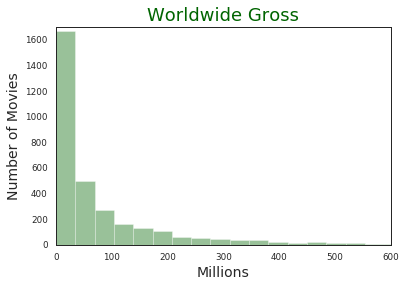

In [28]:
#making Worldwide Gross histogram
sns.set_context('paper')
sns.set_style('white')

sns.distplot(df['Gross'] / 1000000, kde = False, color = 'darkgreen', bins = 80)
plt.ylim(0,1700)
plt.xlim(0,600)
plt.title('Worldwide Gross', color = 'darkgreen', fontsize = 18)
plt.xlabel('Millions', fontsize = 14)
plt.ylabel('Number of Movies', fontsize = 14)
plt.savefig('WorldwideGross_Histogram.png')

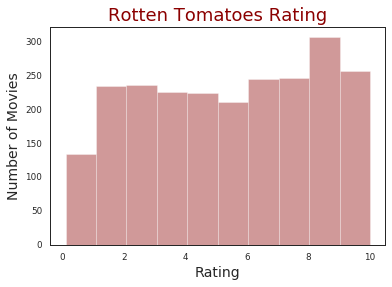

In [29]:
#making Rotten Tomatoes Rating histogram
rtr_df = df['RTRating'].dropna()

sns.distplot(rtr_df, kde = False, color='darkred', bins = 10)
plt.title('Rotten Tomatoes Rating',color = 'darkred', fontsize = 18)
plt.xlabel('Rating', fontsize = 14)
plt.ylabel('Number of Movies', fontsize = 14)
 
plt.savefig('RottenTomatoesRating_Histogram.png')

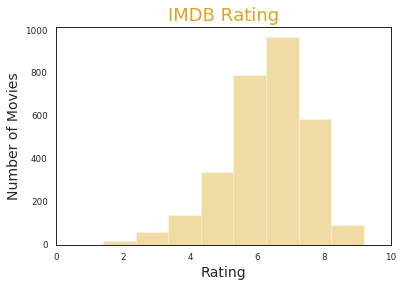

In [30]:
#making IMDB Rating histogram
imdbr_df = df['IMDBRating'].dropna()

sns.distplot(imdbr_df, kde = False, color='goldenrod', bins = 8)
plt.xlim(0, 10)
plt.title('IMDB Rating',color = 'goldenrod', fontsize = 18)
plt.xlabel('Rating', fontsize = 14)
plt.ylabel('Number of Movies', fontsize=14)

plt.savefig('IMDBRating_Histogram.png')

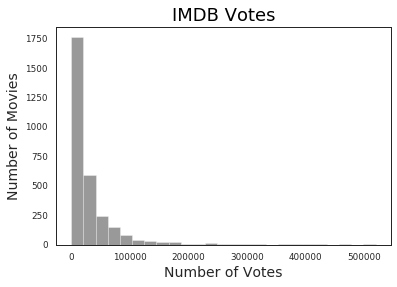

In [33]:
#making IMDB Votes histogram
imdbv_df = df['IMDBVotes'].dropna()

sns.distplot(imdbv_df, kde = False, color = 'black', bins = 25)
plt.title('IMDB Votes',color = 'black', fontsize = 18)
plt.xlabel('Number of Votes', fontsize = 14)
plt.ylabel('Number of Movies', fontsize = 14)

plt.savefig('IMDBVotes_Histogram.png')

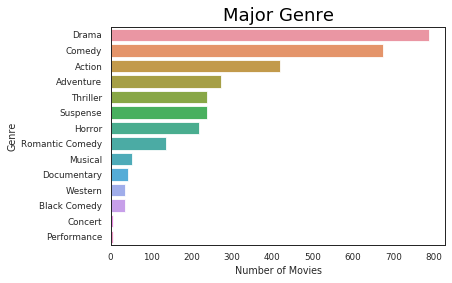

In [34]:
#making Genres bar plot
sns.barplot(x = 'Number of Movies', y = 'Genre', data = genre_numbers_df)
plt.title('Major Genre', color = 'black', fontsize = 18)

plt.savefig('num_movie_genre_barplot.png')